# Prototyping the whole scenario

---



In [52]:
from pydantic import BaseModel, Field
from typing import List, Literal, Any, Optional,Tuple
from datetime import datetime


Verdict = Literal["A", "R", "E"]  # Answer, Request Info, Escalate


class SupportTicketState(BaseModel):
    # -------------------------
    # Identity
    # -------------------------
    ticket_id: str

    # -------------------------
    # User input
    # -------------------------
    ticket_text: str = Field(description="Latest user message")
    messages: List[Tuple[str,str]] = Field(default_factory=list)

    # -------------------------
    # Extracted information
    # -------------------------
    info_list: List[str] = Field(
        default_factory=list,
        description="All confirmed facts provided by the user"
    )

    # -------------------------
    # Knowledge & retrieval
    # -------------------------
    retrieved_from_kb: List[Any] = Field(
        default_factory=list,
        description="KB + past ticket retrieval results"
    )

    # -------------------------
    # Decision intelligence
    # -------------------------
    confidence: float = Field(
        ge=0.0,
        le=1.0,
        description="Confidence in ability to auto-resolve"
    )

    current_verdict: Optional[Verdict] = None
    final_verdict: Optional[Verdict] = None

    number_of_request_infos: int = 0

    # -------------------------
    # SLA & timing (NON-NEGOTIABLE)
    # -------------------------
    ticket_created_at: datetime
    last_agent_action_at: Optional[datetime] = None
    last_user_message_at: Optional[datetime] = None

    sla_seconds: int = Field(description="Maximum allowed response time")

    # -------------------------
    # Output (only valid if ANSWER)
    # -------------------------
    answer: Optional[str] = None


In [38]:
class ExtractedFormat(BaseModel):
    facts: List[str] = Field(
        description="Explicit factual statements stated by the user, not assumptions"
    )

In [39]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a fact extraction component for a technical support system.

Rules:
- Extract ONLY information explicitly stated by the user
- Do NOT infer or guess
- Do NOT troubleshoot or explain
- Do NOT include opinions or emotions
- If no facts are present, return an empty list

Return the result strictly in the required structured format.
"""),
    ("human", "{message}")
])


extract_llm = ChatGroq(model='llama-3.1-8b-instant').with_structured_output(ExtractedFormat)


extract_chain = prompt | extract_llm

In [40]:
extracted = extract_chain.invoke({"message": 'I use Arch btw'})
extracted


ExtractedFormat(facts=['Arch'])

In [41]:
from datetime import datetime

def parse_and_update_state(state, user_input):
    # Update raw input
    state.ticket_text = user_input
    state.messages.append(user_input)

    # Extract facts (structured output)
    extracted = extract_chain.invoke({"message": user_input})

    # Merge facts safely (idempotent behavior)
    for fact in extracted.facts:
        if fact not in state.info_list:
            state.info_list.append(fact)

    # Timestamp user interaction
    state.last_user_message_at = datetime.utcnow()

    return state


In [53]:
from datetime import datetime, timedelta

example_state = SupportTicketState(
    ticket_id="TICKET-123",
    ticket_text="",
    messages=[
        ('user',"My app crashes when I open it")
    ],
    info_list=[
        "App crashes on launch"
    ],
    retrieved_from_kb=[],
    confidence=0.0,
    current_verdict=None,
    final_verdict=None,
    number_of_request_infos=1,
    ticket_created_at=datetime.utcnow() - timedelta(hours=2),
    last_agent_action_at=datetime.utcnow() - timedelta(minutes=30),
    sla_seconds=24 * 60 * 60,  # 24 hours
    answer=None
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3803734837.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ticket_created_at=datetime.utcnow() - timedelta(hours=2),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3803734837.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  last_agent_action_at=datetime.utcnow() - timedelta(minutes=30),


In [54]:
user_input = "I am using macOS Ventura on version 2.3.1"

parse_and_update_state(example_state, user_input=user_input)

C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\1959626494.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_user_message_at = datetime.utcnow()


SupportTicketState(ticket_id='TICKET-123', ticket_text='I am using macOS Ventura on version 2.3.1', messages=[('user', 'My app crashes when I open it'), 'I am using macOS Ventura on version 2.3.1'], info_list=['App crashes on launch', 'macOS Ventura', 'version 2.3.1'], retrieved_from_kb=[], confidence=0.0, current_verdict=None, final_verdict=None, number_of_request_infos=1, ticket_created_at=datetime.datetime(2026, 1, 11, 2, 33, 37, 371138), last_agent_action_at=datetime.datetime(2026, 1, 11, 4, 3, 37, 371138), last_user_message_at=datetime.datetime(2026, 1, 11, 4, 33, 41, 295221), sla_seconds=86400, answer=None)

In [ ]:
def faq_rag(state: SupportTicketState):
    return {'retrieved_from_kb': 'Retrieved'}



In [59]:
def parse_node(state: SupportTicketState) -> SupportTicketState:
    from datetime import datetime

    # assuming SupportTicketState has attributes
    user_input = state.ticket_text  # use ticket_text as the user input
    state.messages.append(("user", user_input))
    
    extracted = extract_chain.invoke({"message": user_input})
    if getattr(state, 'retrieved_from_kb', None):
        state.info_list.extend(extracted)
    
    if getattr(state, 'retrieved_from_kb', None):
        state.info_list.extend(state.retrieved_from_kb)

    state.last_agent_action_at = datetime.utcnow()
    return state


In [65]:
def retrieve_node(state: SupportTicketState) -> SupportTicketState:
    """
    Fake retrieval for testing: return random strings instead of real KB.
    """
    fake_results = [f"FAQ snippet {i}" for i in range(1, random.randint(2, 5))]
    state.retrieved_from_kb = [{"source": f"FAQ-{i}", "category": "FAQ", "snippet": s} for i, s in enumerate(fake_results, 1)]
    return state

In [78]:
# -------------------------
# Router Node
# -------------------------
def router_node(state: SupportTicketState) -> SupportTicketState:
    confidence_threshold = 0.7
    escalation_threshold = 2
    
    if state.confidence >= confidence_threshold:
        state.current_verdict = "A"
    elif state.number_of_request_infos >= escalation_threshold:
        state.current_verdict = "E"
    else:
        state.current_verdict = "R"
    
    return state

def route_condition(state: SupportTicketState):
    if state.current_verdict == "A":
        return "answer_node"
    elif state.current_verdict == "E":
        return "escalate_node"
    return "request_node"

In [79]:
parse_node(example_state)

C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3115490718.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()


SupportTicketState(ticket_id='TICKET-123', ticket_text='I am using macOS Ventura on version 2.3.1', messages=[('user', 'My app crashes when I open it'), 'I am using macOS Ventura on version 2.3.1', ('user', 'I am using macOS Ventura on version 2.3.1'), ('user', 'I am using macOS Ventura on version 2.3.1'), ('user', 'I am using macOS Ventura on version 2.3.1'), ('user', 'I am using macOS Ventura on version 2.3.1')], info_list=['App crashes on launch', 'macOS Ventura', 'version 2.3.1'], retrieved_from_kb=[], confidence=0.0, current_verdict=None, final_verdict=None, number_of_request_infos=1, ticket_created_at=datetime.datetime(2026, 1, 11, 2, 33, 37, 371138), last_agent_action_at=datetime.datetime(2026, 1, 11, 4, 53, 7, 916248), last_user_message_at=datetime.datetime(2026, 1, 11, 4, 33, 41, 295221), sla_seconds=86400, answer=None)

In [82]:
from langgraph.graph import StateGraph

def answer_node(state: SupportTicketState) -> SupportTicketState:
    
    state.messages.append(("agent", state.answer))
    state.current_verdict = "A"
    state.final_verdict = "A"
    state.confidence = 1.0
    state.last_agent_action_at = datetime.utcnow()
    return state

def request_info_node(state: SupportTicketState, ) -> SupportTicketState:
    
    info_prompt = "Could you provide more details about your issue?"
    state.messages.append(("agent", info_prompt))
    state.number_of_request_infos += 1
    state.current_verdict = "R"
    state.confidence = 0.0
    state.last_agent_action_at = datetime.utcnow()
    return state

def escalate_node(state: SupportTicketState) -> SupportTicketState:
    
    escalation_note = "Escalating this ticket to a human agent."
    state.messages.append(("agent", escalation_note))
    state.current_verdict = "E"
    state.final_verdict = "E"
    state.confidence = 0.0
    state.last_agent_action_at = datetime.utcnow()
    return state

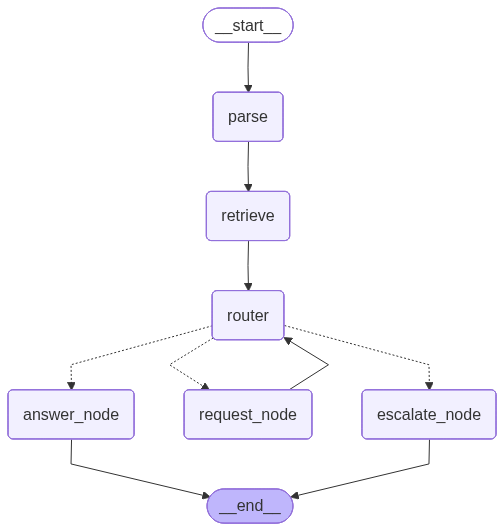

In [83]:
# Build graph
workflow = StateGraph(state_schema=SupportTicketState)

workflow.add_node("parse", parse_node)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("router", router_node)
workflow.add_node("answer_node", answer_node)
workflow.add_node("request_node", request_info_node)
workflow.add_node("escalate_node", escalate_node)

workflow.set_entry_point("parse")
workflow.add_edge("parse", "retrieve")
workflow.add_edge("retrieve", "router")
workflow.add_conditional_edges(
    "router",
    route_condition,
    {
        "answer_node": "answer_node",
        "request_node": "request_node",
        "escalate_node": "escalate_node"
    }
)
workflow.add_edge("request_node", "router")  # Loop back

app = workflow.compile()
app

In [86]:
from datetime import datetime, timedelta

# Initial state
example_state: SupportTicketState = {
    "ticket_id": "TICKET-001",
    "ticket_text": "App crashes on macOS Ventura when opening project",
    "messages": [],
    "info_list": [],
    "retrieved_from_kb": [],
    "confidence": 0.6,  # Triggers "R" -> request_node loop
    "current_verdict": None,
    "final_verdict": None,
    "number_of_request_infos": 0,  # Increase to 2+ for "E"
    "ticket_created_at": datetime.utcnow() - timedelta(hours=1),
    "last_agent_action_at": None,
    "sla_seconds": 86400,
    "answer": ""
}

# Test invoke
result = app.invoke(example_state)

print("Final State:")
print(f"Verdict: {result['current_verdict']}")
print(f"Confidence: {result['confidence']}")
print(f"Request infos: {result['number_of_request_infos']}")
print(f"Last message: {result['messages'][-1]}")
print(f"Answer: {result.get('answer', 'N/A')}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\2011100600.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ticket_created_at": datetime.utcnow() - timedelta(hours=1),


Final State:
Verdict: E
Confidence: 0.0
Request infos: 2
Last message: ('agent', 'Escalating this ticket to a human agent.')
Answer: 


C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3115490718.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()
C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3717937408.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()
C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\3717937408.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()


In [46]:
# test_pipeline_nodes.py

import random
from datetime import datetime


# -------------------------
# Action nodes
# -------------------------
def answer_node(state: SupportTicketState, answer_text: str) -> SupportTicketState:
    state.messages.append(("agent", answer_text))
    state.current_verdict = "A"
    state.final_verdict = "A"
    state.confidence = 1.0
    state.last_agent_action_at = datetime.utcnow()
    state.answer = answer_text
    return state

def request_info_node(state: SupportTicketState, info_prompt: str = None) -> SupportTicketState:
    if info_prompt is None:
        info_prompt = "Could you provide more details about your issue?"
    state.messages.append(("agent", info_prompt))
    state.number_of_request_infos += 1
    state.current_verdict = "R"
    state.confidence = 0.0
    state.last_agent_action_at = datetime.utcnow()
    return state

def escalate_node(state: SupportTicketState, escalation_note: str = None) -> SupportTicketState:
    if escalation_note is None:
        escalation_note = "Escalating this ticket to a human agent."
    state.messages.append(("agent", escalation_note))
    state.current_verdict = "E"
    state.final_verdict = "E"
    state.confidence = 0.0
    state.last_agent_action_at = datetime.utcnow()
    return state

# -------------------------
# Parse Node
# -------------------------
def parse_node(state: SupportTicketState, user_input: str, extracted_facts=None) -> SupportTicketState:
    state.ticket_text = user_input
    state.messages.append(("user", user_input))
    if extracted_facts:
        state.info_list.extend(extracted_facts)
    state.last_agent_action_at = datetime.utcnow()
    return state

# -------------------------
# Fake Retrieve Node
# -------------------------
def retrieve_node(state: SupportTicketState) -> SupportTicketState:
    """
    Fake retrieval for testing: return random strings instead of real KB.
    """
    fake_results = [f"FAQ snippet {i}" for i in range(1, random.randint(2, 5))]
    state.retrieved_from_kb = [{"source": f"FAQ-{i}", "category": "FAQ", "snippet": s} for i, s in enumerate(fake_results, 1)]
    return state

# -------------------------
# Router Node
# -------------------------
def router_node(state: SupportTicketState, confidence_threshold=0.7, escalation_threshold=2) -> SupportTicketState:
    """
    Decide which action node to call.
    """
    if state.confidence >= confidence_threshold:
        return answer_node(state, "Here is the answer based on retrieved info.")
    elif state.number_of_request_infos >= escalation_threshold:
        return escalate_node(state)
    else:
        return request_info_node(state)

# -------------------------
# Example test pipeline
# -------------------------
if __name__ == "__main__":
    from datetime import timedelta

    # Mock ticket state
    state = SupportTicketState(
        ticket_id="TICKET-TEST",
        ticket_text="",
        messages=[],
        info_list=[],
        retrieved_from_kb=[],
        confidence=0.5,
        current_verdict=None,
        final_verdict=None,
        number_of_request_infos=0,
        ticket_created_at=datetime.utcnow() - timedelta(hours=1),
        last_agent_action_at=None,
        sla_seconds=24*60*60
    )

    # User message
    user_message = "App crashes on macOS Ventura when opening a project."

    # 1️⃣ Parse
    state = parse_node(state, user_message, extracted_facts=["OS: macOS Ventura", "App crashes on open project"])

    # 2️⃣ Fake retrieve
    state = retrieve_node(state)

    # 3️⃣ Router chooses action node
    state = router_node(state)

    # Print final state for testing
    print("\n--- Test Pipeline Output ---")
    print(f"Ticket text: {state.ticket_text}")
    print(f"Info list: {state.info_list}")
    print(f"Retrieved KB: {[r['snippet'] for r in state.retrieved_from_kb]}")
    print(f"Current verdict: {state.current_verdict}")
    print(f"Confidence: {state.confidence}")
    print(f"Final verdict: {state.final_verdict}")
    print(f"Number of request info: {state.number_of_request_infos}")
    print(f"Messages: {state.messages}")



--- Test Pipeline Output ---
Ticket text: App crashes on macOS Ventura when opening a project.
Info list: ['OS: macOS Ventura', 'App crashes on open project']
Retrieved KB: ['FAQ snippet 1', 'FAQ snippet 2', 'FAQ snippet 3', 'FAQ snippet 4']
Current verdict: R
Confidence: 0.0
Final verdict: None
Number of request info: 1
Messages: [('user', 'App crashes on macOS Ventura when opening a project.'), ('agent', 'Could you provide more details about your issue?')]


C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\1746296480.py:92: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ticket_created_at=datetime.utcnow() - timedelta(hours=1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\1746296480.py:47: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()
C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\1746296480.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  state.last_agent_action_at = datetime.utcnow()


C:\Users\DELL\AppData\Local\Temp\ipykernel_21892\1919337712.py:120: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ticket_created_at": datetime.utcnow() - timedelta(hours=1),


TypeError: parse_node() missing 1 required positional argument: 'user_input'